# Action potentials of Paramecium

In [1]:
import sys
sys.path.append('/Users/romainbrette/PycharmProjects/brian2') # my local install of Brian
sys.path.append('/Users/romainbrette/PycharmProjects/clampy') # my local install of Clampy

In [4]:
%matplotlib ipympl
from behavior.models import *

We load parameters fitted to one particular cell.

In [5]:
parameters = paramecium_constants(name = '2020-05-20 19.42.53')
parameters['C']

0.41 * nfarad

We define the equations. The stimulus is a pulse of current with graded intensity.

In [6]:
from brian2 import *

t1 = 300*ms
t2 = 310*ms

eqs = Equations('''
            ## Membrane equation
            dv/dt = (IL+ICa_cilia+IK+IKCa_cilia+I)/C : volt
            I = I0*(int(t>t1)*int(t<t2)) : amp
            I0 : amp (constant)

            ## Currents
            IL = gL*(EL-v) : amp
            IV_K = (EK-v)/DV : 1
            IV_Ca = 1/exprel(2*v/DV) : 1
            
            ## IK (rectifier)
            IK = g_IK * n_IK**2 * IV_K : amp
            ninf_IK = 1/(1+exp((V_IK-v)/k_IK)) : 1
            dn_IK / dt = (ninf_IK - n_IK)/tau_IK: 1
            tau_IK = a_IK + b_IK/(cosh((v-V_IK)/(2*k_IK))) : second
                      
            ### ICa_cilia (depolarization-activated)
            ICa_cilia = gCa_cilia*m_Ca_cilia**2*h_Ca_cilia*IV_Ca : amp
            dm_Ca_cilia/dt = (minf_Ca_cilia-m_Ca_cilia)/taum_Ca_cilia : 1
            minf_Ca_cilia = 1/(1+exp((VCa_cilia-v)/kCa_cilia)) : 1
            h_Ca_cilia = 1/(1+exp(nCaM_Ca_cilia*(pCa-pKCa))) : 1
            
            ### IK(Ca)
            IKCa_cilia = gKCa_cilia / (1+ exp(-nCaM_KCa_cilia*(pCa-pKKCa)))* IV_K : amp # gKCa is the amplitude at 10 uM
            
            #### Calcium dynamics ####
            dpCa/dt = ICa_cilia/(2*F*Cai0_cilia*v_cilia)*exp(-pCa) + alpha_cilia*(exp(-pCa)-1)- Jpump_cilia : 1
            Jpump_cilia = Jpumpmax_cilia / (1+exp(pCa)) : 1/second
            Cai_cilia = Cai0_cilia*exp(pCa) : mM
            
            ### Electromotor coupling
            velocity = -v_plus + 2*v_plus/(1+(Cai_cilia/K_electromotor)**2) : meter/second (constant over dt)
            theta = theta_min + 2*(theta_max-theta_min)/((K_electromotor/Cai_cilia)**2 + (Cai_cilia/K_electromotor)**2) : 1 (constant over dt)
            omega = omega_min + 2*(omega_max-omega_min)/((K_electromotor/Cai_cilia)**2 + (Cai_cilia/K_electromotor)**2) : 1/second (constant over dt)
            ''', **parameters)

We simulate 10 neurons over 500 ms.

In [7]:
N = 10
neuron = NeuronGroup(N, eqs)
neuron.v = parameters['EL']
neuron.I0 = linspace(0, 2, N)*nA

M = StateMonitor(neuron, ('v', 'Cai_cilia', 'velocity', 'ICa_cilia', 'IK', 'IKCa_cilia'), record=True)

Network([neuron,M]).run(700*ms)

WARNING    Cannot use Cython, a test compilation failed: Cython is not available (ImportError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.04s, trying other methods took 0.14s). [brian2.stateupdaters.base.method_choice]


We plot the traces.

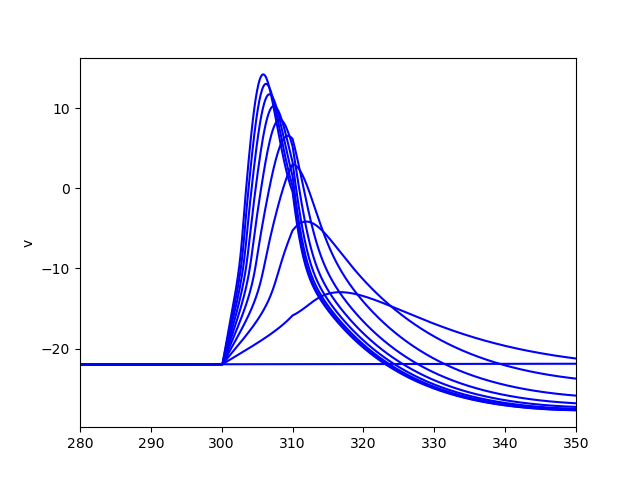

In [9]:
#from matplotlib import pyplot as plt

figure()
for i in range(N):
    plot(M.t/ms, M.v[i]/mV, 'b')
xlim(280,350)
ylabel('v')
show()

Let's look at the currents (electrophysiological convention: <0 is inward).

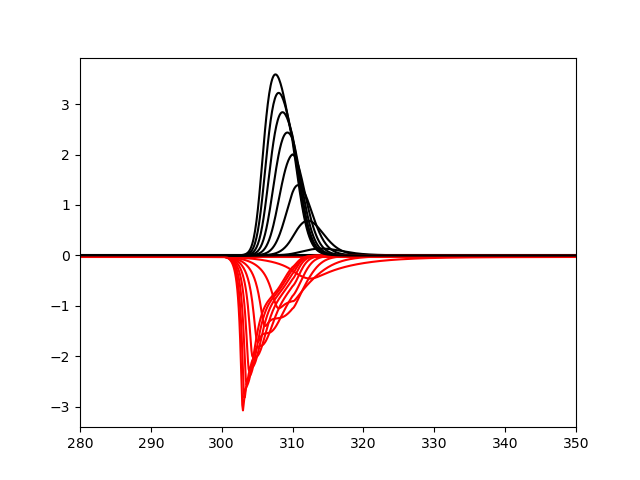

In [11]:
figure()
for i in range(N):
    plot(M.t/ms, -M.ICa_cilia[i]/nA, 'r')
    plot(M.t/ms, -M.IK[i]/nA, 'k')
xlim(280,350)
show()